# COMP30027 - Project 2A

## N.B. I have modified the CSV files to contain the headers written in the README.

Author: Daniel Masters (58334)
Some code used from: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

In [2]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB

train_df = pd.read_csv('train_raw.csv', sep=',')
train_df.head()

,User_ID,Gender,Age,Occupation,Star_Sign,Date,Text
0,5114,male,25,indUnk,Scorpio,"01,May,2001",Douglas Rushkoff's Frontline docu...
1,5114,male,25,indUnk,Scorpio,"01,May,2001",I'm DSLless for 10 days. I suppo...
2,5114,male,25,indUnk,Scorpio,"01,October,2001",Crap. I ordered the new Citizen ...
3,5114,male,25,indUnk,Scorpio,"01,October,2002",I can't get enough of CBC's urlL...
4,5114,male,25,indUnk,Scorpio,"01,October,2002",In case anyone's sitting on the e...


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276415 entries, 0 to 276414
Data columns (total 7 columns):
User_ID       276415 non-null int64
Gender        276415 non-null object
Age           276415 non-null int64
Occupation    276415 non-null object
Star_Sign     276415 non-null object
Date          276415 non-null object
Text          276415 non-null object
dtypes: int64(2), object(5)
memory usage: 14.8+ MB


In [4]:
col = ['User_ID', 'Text', 'Age']
train_df = train_df[col]

In [5]:
train_df['Age'] = train_df['Age'].astype(int).astype(str)
train_df['Age'] = train_df['Age'].astype(str)

In [6]:
train_df['Age'] = train_df['Age'].replace({'14': '14-16', '15': '14-16', '16': '14-16', '24': '24-26', '25': '24-26', '26': '24-26', '34': '34-36', 
                   '35': '34-36', '36': '34-36', '44': '44-46', '45': '44-46', '46': '44-46'}).astype(str)
train_df['Text'] = train_df['Text'].str.replace('[^\w\s]','')
train_df['Text'] = train_df['Text'].str.lower()

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276415 entries, 0 to 276414
Data columns (total 3 columns):
User_ID    276415 non-null int64
Text       276415 non-null object
Age        276415 non-null object
dtypes: int64(1), object(2)
memory usage: 6.3+ MB


In [8]:
train_df['category_id'] = train_df['Age'].factorize()[0]
from io import StringIO
category_id_df = train_df[['Age', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Age']].values)
train_df = train_df.groupby(['User_ID'],as_index=False).first()

In [9]:
train_df.head()

,User_ID,Text,Age,category_id
0,5114,douglas rushkoffs frontline docum...,24-26,0
1,7596,i received a short email from the local...,24-26,0
2,8349,i need more time in the day where i...,24-26,0
3,11762,entry originally posted on 8 august 20...,24-26,0
4,15365,betrayed 219 am birthed the aries moon ...,34-36,1


UsageError: unrecognized arguments: plt


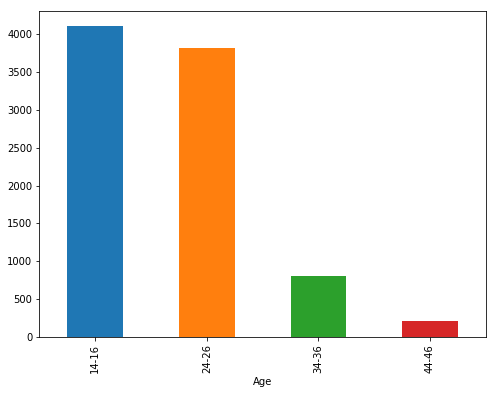

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_df.groupby('Age').Text.count().plot.bar(ylim=0)
%matplotlib inline plt

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(train_df.Text)
labels = train_df.category_id
features.shape

(8950, 25095)

In [12]:
from sklearn.feature_selection import chi2
tokens = []
N = 16
for Age, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Age))
    print("    Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("    Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))
    tokens.append(bigrams[-N:])
    tokens.append(unigrams[-N:])
tokens = [val for sublist in tokens for val in sublist]

# '14-16':
    Most correlated unigrams:
       . noe
       . yeah
       . wif
       . tt
       . ur
       . ppl
       . den
       . urllink
       . dun
       . ya
       . wanna
       . school
       . cuz
       . gonna
       . haha
       . lol
    Most correlated bigrams:
       . came home
       . im goin
       . new job
       . drivers ed
       . uploaded urllink
       . originally uploaded
       . dont wanna
       . im gunna
       . school starts
       . gonna miss
       . im bored
       . national day
       . write later
       . havent posted
       . menbsp urllink
       . im gonna
# '24-26':
    Most correlated unigrams:
       . mi
       . wad
       . noe
       . wif
       . ur
       . ppl
       . tt
       . wanna
       . den
       . dun
       . school
       . ya
       . cuz
       . gonna
       . haha
       . lol
    Most correlated bigrams:
       . getting married
       . im gunna
       . johnny cash
       . national day
       . 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(train_df['Text'], train_df['Age'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
print(clf.predict(count_vect.transform(["baby lyk im so"])))

['14-16']


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.646037
LogisticRegression        0.670171
MultinomialNB             0.666037
RandomForestClassifier    0.504357
Name: accuracy, dtype: float64

In [17]:
import pandas as pd
dev_df = pd.read_csv('dev_raw.csv', sep=',')

col = ['User_ID', 'Text', 'Age']
dev_df = dev_df[col]

dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45332 entries, 0 to 45331
Data columns (total 3 columns):
User_ID    45332 non-null int64
Text       45332 non-null object
Age        45332 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [18]:
dev_df['Age'] = dev_df['Age'].astype(int).astype(str)
dev_df['Age'] = dev_df['Age'].astype(str)

dev_df['Age'] = dev_df['Age'].replace({'14': '14-16', '15': '14-16', '16': '14-16', '24': '24-26', '25': '24-26', '26': '24-26', '34': '34-36', 
                   '35': '34-36', '36': '34-36', '44': '44-46', '45': '44-46', '46': '44-46'}).astype(str)

dev_df = dev_df.groupby(['User_ID'],as_index=False).first()
dev_df.groupby('Age')
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 0 to 1496
Data columns (total 3 columns):
User_ID    1497 non-null int64
Text       1497 non-null object
Age        1497 non-null object
dtypes: int64(1), object(2)
memory usage: 46.8+ KB


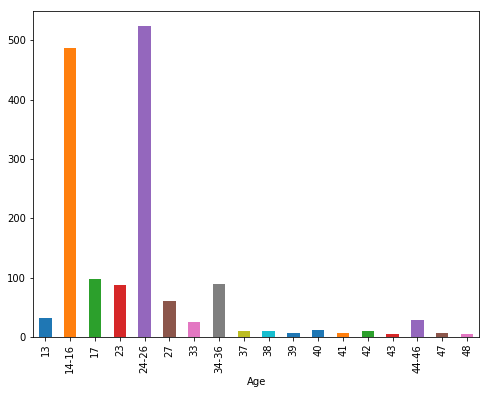

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dev_df.groupby('Age').Text.count().plot.bar(ylim=0)
plt.show()

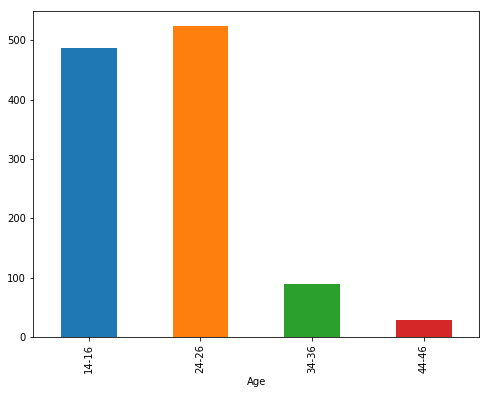

In [20]:
dev_df['Text'] = dev_df['Text'].str.lower()
age_classes = ['14-16', '24-26', '34-36', '44-46']
dev_df = dev_df[dev_df['Age'].isin(age_classes)]
fig = plt.figure(figsize=(8,6))
dev_df.groupby('Age').Text.count().plot.bar(ylim=0)
plt.show()

In [21]:
dev_df.loc[:,'Text'] = dev_df.loc[:,'Text'].str.replace('[^\w\s]','')

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(vocabulary=set(tokens))
train_tokenised = pd.DataFrame(countvec.fit_transform(train_df.Text).toarray(), index=train_df.User_ID, columns=countvec.get_feature_names())
dev_tokenised = pd.DataFrame(countvec.fit_transform(dev_df.Text).toarray(), index=dev_df.User_ID, columns=countvec.get_feature_names())

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(train_tokenised.values, train_df['Age'])
dev_pred = model.predict(dev_tokenised)

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(dev_df['Age'], dev_pred)

0.5611702127659575

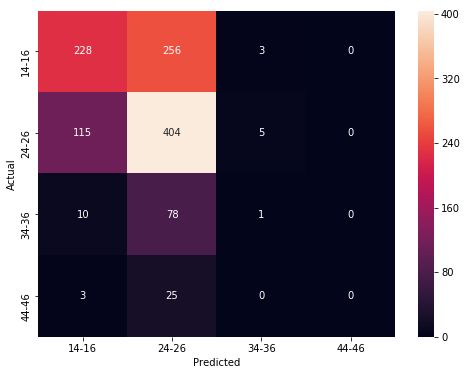

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(dev_df['Age'], dev_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=age_classes, yticklabels=age_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(train_tokenised.values, train_df['Age'])
dev_pred = model.predict(dev_tokenised)

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(dev_df['Age'], dev_pred)

0.49645390070921985

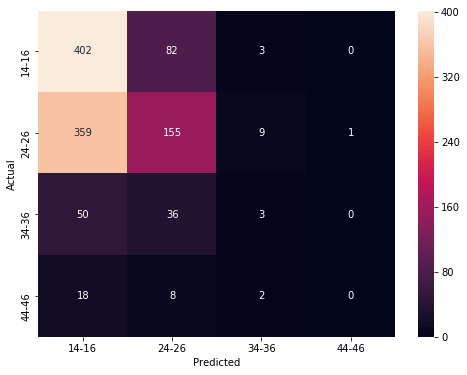

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(dev_df['Age'], dev_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=age_classes, yticklabels=age_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
test_df = pd.read_csv('test_raw.csv', sep=',')

In [31]:
test_df = test_df[col]
test_df = test_df.groupby(['User_ID'],as_index=False).first()
test_df.loc[:,'Text'] = test_df.loc[:,'Text'].str.replace('[^\w\s]','')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1391 entries, 0 to 1390
Data columns (total 3 columns):
User_ID    1391 non-null int64
Text       1391 non-null object
Age        1391 non-null object
dtypes: int64(1), object(2)
memory usage: 43.5+ KB


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(vocabulary=set(tokens))
test_tokenised = pd.DataFrame(countvec.fit_transform(test_df.Text).toarray(), index=test_df.User_ID, columns=countvec.get_feature_names())

,28,35 years,ale,believe know,benbsp,blood pressure,builder,came home,check things,cuz,...,wanna,weekend trip,wif,wonderful day,wonderful friends,wont going,world blogging,write later,ya,yeah
User_ID,,,,,,,,,,,,,,,,,,,,,
9470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
207842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(train_tokenised.values, train_df['Age'])
test_pred_LR = model.predict(test_tokenised)
np.savetxt('test_pred_LogisticRegression.txt', test_pred_LR, fmt='%5s', delimiter=',')

In [41]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(train_tokenised.values, train_df['Age'])
test_pred_MNB = model.predict(test_tokenised)
np.savetxt('test_pred_MultinomialNB.txt', test_pred_MNB, fmt='%5s', delimiter=',')